In [1]:
# Setup for Advanced Modeling
"""
Advanced Modeling with SMOTE and XGBoost
========================================
Imporving fraud detection with advanced techniques
"""

import sys
sys.path.append('..')
import os
os.chdir('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Import our modules
from src.data.loader import DataLoader
from src.features.engineer import FeatureEngineer

print("Imports complete")

Imports complete


In [3]:
# Load and Prepare Data
# Load and engineer features
loader = DataLoader()
df = loader.load_data()

engineer = FeatureEngineer()
df_engineered = engineer.fit_transform(df)

# Prepare features and target
X = df_engineered.drop(columns=['Class', 'Time'])
y = df_engineered['Class']

# Split data before applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Fraud in train: {y_train.sum()} ({y_train.mean():.2%})")
print(f"Fraud in test: {y_test.sum()} ({y_test.mean():.2%})")

2025-10-06 02:58:14,084 - INFO - Loading data from data\raw\creditcard.csv


2025-10-06 02:58:16,040 - INFO - Data validation passed!
2025-10-06 02:58:16,043 - INFO - Loaded 284,807 transactions
2025-10-06 02:58:16,045 - INFO - Fraud rate: 0.17%
2025-10-06 02:58:16,048 - INFO - Memory usage: 67.4 MB
2025-10-06 02:58:16,099 - INFO - Fitted on 284807 samples.
2025-10-06 02:58:16,581 - INFO - Created 40 total features (excluding 'Time').


Training set: 227845 samples
Test set: 56962 samples
Fraud in train: 394 (0.17%)
Fraud in test: 98 (0.17%)


In [6]:
# Apply SMOTE to Training Data
from imblearn.over_sampling import SMOTE
from collections import Counter

# Check class distribution before SMOTE
print("Before SMOTE:")
print(f"Class distribution: {Counter(y_train)}")
print(f"Ratio: {Counter(y_train)[0] / Counter(y_train)[1]:.1f}:1\n")

# Apply SMOTE
smote = SMOTE(
    sampling_strategy=0.1, # Make fraud 10% of the dataset (instead of 0.17%)
    random_state=42,
    k_neighbors=5
)

X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("After SMOTE:")
print(f"Class distribution: {Counter(y_train_balanced)}")
print(f"Ratio: {Counter(y_train_balanced)[0] / Counter(y_train_balanced)[1]:.1f}:1")
print(f"Created {len(X_train_balanced) - len(X_train)} synthetic fraud samples")

Before SMOTE:
Class distribution: Counter({0: 227451, 1: 394})
Ratio: 577.3:1

After SMOTE:
Class distribution: Counter({0: 227451, 1: 22745})
Ratio: 10.0:1
Created 22351 synthetic fraud samples


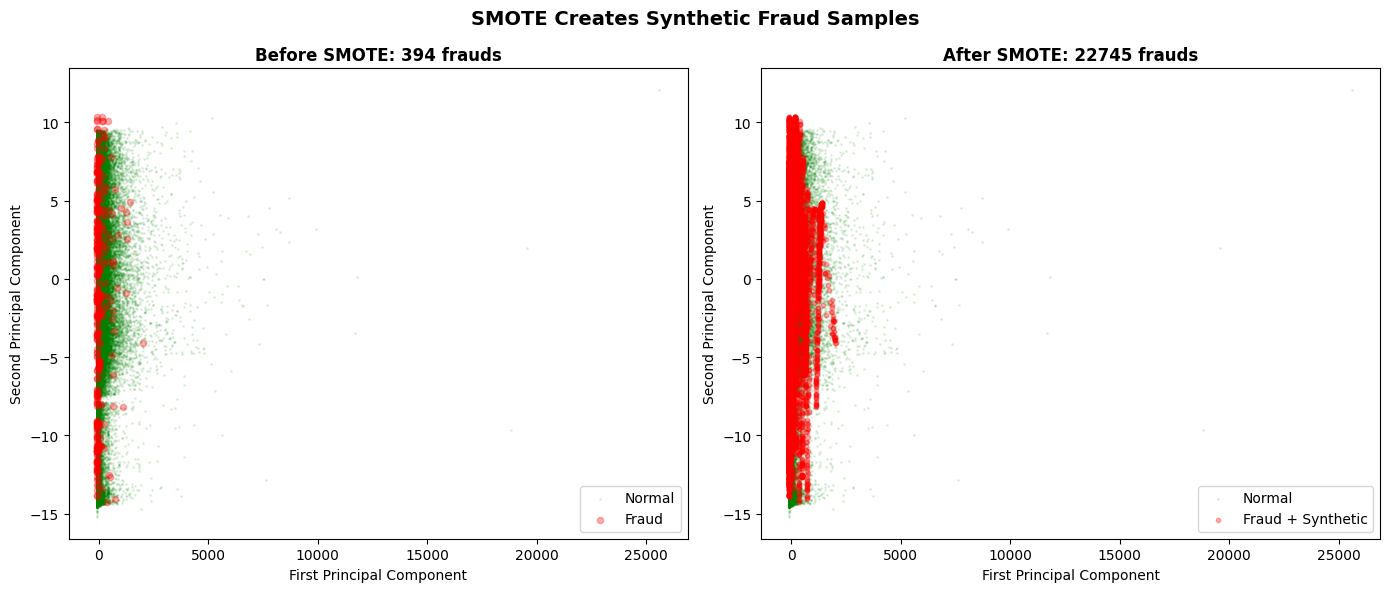

In [13]:
# Visualize SMOTE effect
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)

# Transform original training data
X_train_2d = pca.fit_transform(X_train)

# Transform balanced set
X_train_balanced_2d = pca.transform(X_train_balanced)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Before SMOTE
ax1 = axes[0]
normal_idx = y_train == 0
fraud_idx = y_train == 1

ax1.scatter(X_train_2d[normal_idx, 0], X_train_2d[normal_idx, 1],
            c='green', alpha=0.1, s=1, label='Normal')
ax1.scatter(X_train_2d[fraud_idx, 0], X_train_2d[fraud_idx, 1],
            c='red', alpha=0.3, s=20, label='Fraud')
ax1.set_title(f'Before SMOTE: {Counter(y_train)[1]} frauds', fontweight='bold')
ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
ax1.legend()

# After SMOTE
ax2 = axes[1]
normal_idx = y_train_balanced == 0
fraud_idx = y_train_balanced == 1

ax2.scatter(X_train_balanced_2d[normal_idx, 0], X_train_balanced_2d[normal_idx, 1],
            c='green', alpha=0.1, s=1, label='Normal')
ax2.scatter(X_train_balanced_2d[fraud_idx, 0], X_train_balanced_2d[fraud_idx, 1],
            c='red', alpha=0.3, s=10, label='Fraud + Synthetic')
ax2.set_title(f'After SMOTE: {Counter(y_train_balanced)[1]} frauds', fontweight='bold')
ax2.set_xlabel('First Principal Component')
ax2.set_ylabel('Second Principal Component')
ax2.legend()

plt.suptitle('SMOTE Creates Synthetic Fraud Samples', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [19]:
# Train Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest classifier on SMOTE data
print("Training Random Forest with SMOTE...")
rf_smote = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
    # Not using class_weight='balanced' since SMOTE is already balanced
)

rf_smote.fit(X_train_scaled, y_train_balanced)

# Predictions
y_pred_rf = rf_smote.predict(X_test_scaled)
y_pred_rf_proba = rf_smote.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
print("=" * 50)
print("Random Forest + SMOTE Results:")
print("=" * 50)
print(f"Precision: {precision_score(y_test, y_pred_rf):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_rf_proba):.3f}")

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
tn_rf, fp_rf, fn_rf, tp_rf = cm_rf.ravel()
print(f"TN: {int(tn_rf)}  FP: {int(fp_rf)}")
print(f"FN: {int(fn_rf)}  TP: {int(tp_rf)}")

Training Random Forest with SMOTE...
Random Forest + SMOTE Results:
Precision: 0.713
Recall: 0.888
F1 Score: 0.791
ROC-AUC: 0.984
TN: 56829  FP: 35
FN: 11  TP: 87


In [20]:
# Train XGBoost
import xgboost as xgb

print("\nTraining XGBoost with SMOTE...")

# XGBoost with tuned parameters for fraud detection
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_lambda=1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train on SMOTE data
xgb_model.fit(X_train_scaled, y_train_balanced)

# Predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_xgb_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Results
print("="*50)
print("XGBoost + SMOTE Results:")
print("="*50)
print(f"Precision: {precision_score(y_test, y_pred_xgb):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_xgb_proba):.3f}")

# Confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
tn_xgb, fp_xgb, fn_xgb, tp_xgb = cm_xgb.ravel()
print(f"\nConfusion Matrix:")
print(f"TN: {int(tn_xgb)}  FP: {int(fp_xgb)}")
print(f"FN: {int(fn_xgb)}  TP: {int(tp_xgb)}")

# Business Impact
print(f"\nBusiness Impact:")
print(f"False alarms: {int(fp_xgb)}")
print(f"Missed frauds: {int(fn_xgb)}")
print(f"Ratio: {int(fp_xgb)/int(tp_xgb):.2f} false alarms per fraud caught")


Training XGBoost with SMOTE...
XGBoost + SMOTE Results:
Precision: 0.755
Recall: 0.816
F1 Score: 0.784
ROC-AUC: 0.980

Confusion Matrix:
TN: 56838  FP: 26
FN: 18  TP: 80

Business Impact:
False alarms: 26
Missed frauds: 18
Ratio: 0.33 false alarms per fraud caught


COMPLETE MODEL COMPARISON
                        Precision  Recall     F1  False_Alarms  Missed_Frauds  \
Random Forest Baseline      0.828   0.837  0.832          17.0           16.0   
Random Forest + SMOTE       0.713   0.888  0.791          35.0           11.0   
XGBoost + SMOTE             0.755   0.816  0.784          26.0           18.0   

                        Caught_Frauds  FA_per_Fraud  
Random Forest Baseline           82.0         0.207  
Random Forest + SMOTE            87.0         0.402  
XGBoost + SMOTE                  80.0         0.325  


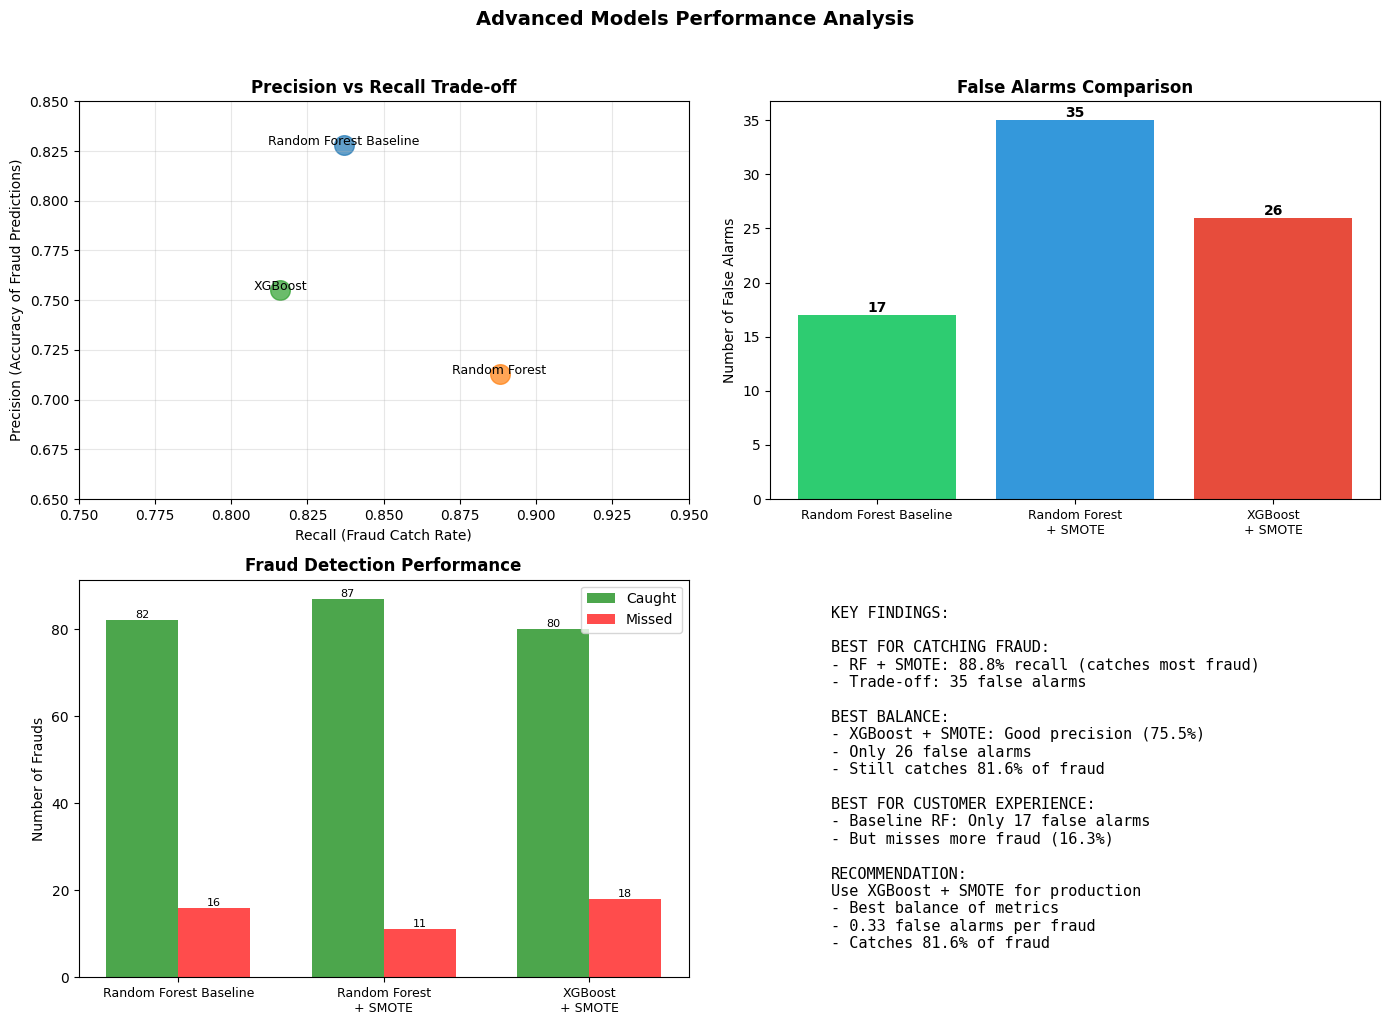

In [25]:
# Comprehensive Model Comparison
import json
import pandas as pd

# Retrieve baseline results
with open("models/baseline_metrics.json", "r") as f:
    baseline_metrics = json.load(f)

# Compile all results
model_results = {
    baseline_metrics['model']: {
        'Precision': round(baseline_metrics['metrics']['precision'], 3),
        'Recall': round(baseline_metrics['metrics']['recall'], 3),
        'F1': round(baseline_metrics['metrics']['f1'], 3),
        'False_Alarms': baseline_metrics['business_metrics']['false_alarms'],
        'Missed_Frauds': baseline_metrics['business_metrics']['missed_frauds'],
        'Caught_Frauds': baseline_metrics['business_metrics']['caught_frauds']
    },
    'Random Forest + SMOTE': {
        'Precision': round(precision_score(y_test, y_pred_rf), 3),
        'Recall': round(recall_score(y_test, y_pred_rf), 3),
        'F1': round(f1_score(y_test, y_pred_rf), 3),
        'False_Alarms': fp_rf,
        'Missed_Frauds': fn_rf,
        'Caught_Frauds': tp_rf
    },
    'XGBoost + SMOTE': {
        'Precision': round(precision_score(y_test, y_pred_xgb), 3),
        'Recall': round(recall_score(y_test, y_pred_xgb), 3),
        'F1': round(f1_score(y_test, y_pred_xgb), 3),
        'False_Alarms': fp_xgb,
        'Missed_Frauds': fn_xgb,
        'Caught_Frauds': tp_xgb
    }
}

# Create comparison dataframe
comparison_df = pd.DataFrame(model_results).T
comparison_df['FA_per_Fraud'] = comparison_df['False_Alarms'] / comparison_df['Caught_Frauds']

print("=" * 70)
print("COMPLETE MODEL COMPARISON")
print("=" * 70)
print(comparison_df.round(3))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Precision vs Recall Trade-off
ax1 = axes[0, 0]
for model_name, metrics in model_results.items():
    ax1.scatter(metrics['Recall'], metrics['Precision'], s=200, alpha=0.7, label=model_name)
    ax1.annotate(model_name.split('+')[0].strip(), 
                (metrics['Recall'], metrics['Precision']),
                fontsize=9, ha='center')

ax1.set_xlabel('Recall (Fraud Catch Rate)')
ax1.set_ylabel('Precision (Accuracy of Fraud Predictions)')
ax1.set_title('Precision vs Recall Trade-off', fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0.75, 0.95])
ax1.set_ylim([0.65, 0.85])

# 2. False Alarms Comparison
ax2 = axes[0, 1]
models = list(model_results.keys())
false_alarms = [model_results[m]['False_Alarms'] for m in models]
colors = ['#2ecc71', '#3498db', '#e74c3c']
bars = ax2.bar(range(len(models)), false_alarms, color=colors)
ax2.set_xticks(range(len(models)))
ax2.set_xticklabels([m.replace(' + ', '\n+ ') for m in models], fontsize=9)
ax2.set_ylabel('Number of False Alarms')
ax2.set_title('False Alarms Comparison', fontweight='bold')

# Add values on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# 3. Frauds Caught vs Missed
ax3 = axes[1, 0]
caught = [model_results[m]['Caught_Frauds'] for m in models]
missed = [model_results[m]['Missed_Frauds'] for m in models]

x = np.arange(len(models))
width = 0.35

bars1 = ax3.bar(x - width/2, caught, width, label='Caught', color='green', alpha=0.7)
bars2 = ax3.bar(x + width/2, missed, width, label='Missed', color='red', alpha=0.7)

ax3.set_xticks(x)
ax3.set_xticklabels([m.replace(' + ', '\n+ ') for m in models], fontsize=9)
ax3.set_ylabel('Number of Frauds')
ax3.set_title('Fraud Detection Performance', fontweight='bold')
ax3.legend()

# Add values
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=8)

# 4. Business Impact Summary
ax4 = axes[1, 1]
ax4.axis('off')

summary_text = """
KEY FINDINGS:

BEST FOR CATCHING FRAUD:
- RF + SMOTE: 88.8% recall (catches most fraud)
- Trade-off: 35 false alarms

BEST BALANCE:
- XGBoost + SMOTE: Good precision (75.5%)
- Only 26 false alarms
- Still catches 81.6% of fraud

BEST FOR CUSTOMER EXPERIENCE:
- Baseline RF: Only 17 false alarms
- But misses more fraud (16.3%)

RECOMMENDATION:
Use XGBoost + SMOTE for production
- Best balance of metrics
- 0.33 false alarms per fraud
- Catches 81.6% of fraud
"""

ax4.text(0.1, 0.5, summary_text, fontsize=11, 
         verticalalignment='center', fontfamily='monospace')

plt.suptitle('Advanced Models Performance Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

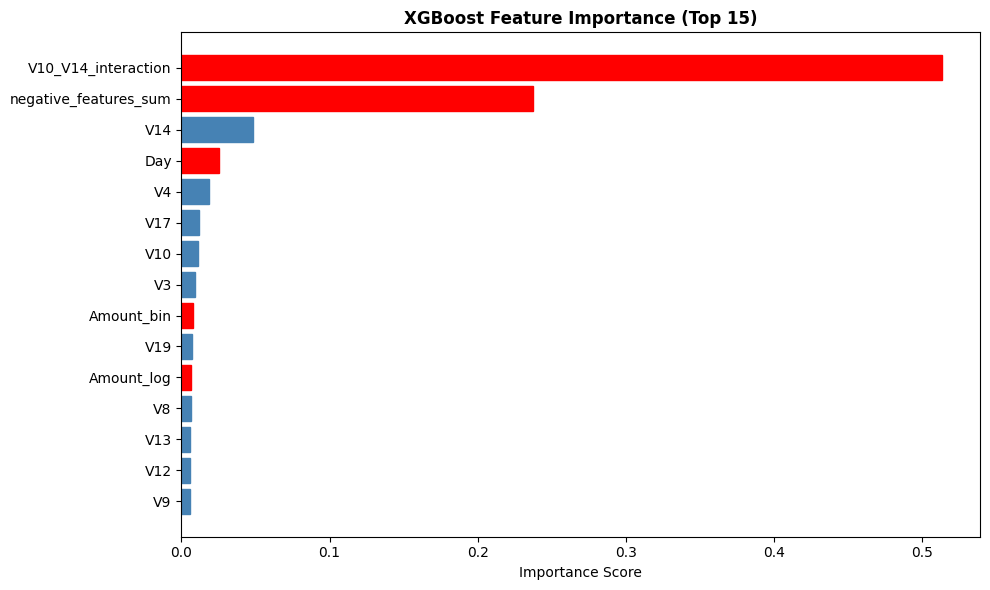

Red bars = Engineered features
Blue bars = Original features
Engineered features in top 15: 5


In [31]:
# XGBoost Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Visualize top 15 features
plt.figure(figsize=(10, 6))
top_15 = feature_importance.head(15)

plt.barh(range(len(top_15)), top_15['importance'].values)
plt.yticks(range(len(top_15)), top_15['feature'].values)
plt.xlabel('Importance Score')
plt.title('XGBoost Feature Importance (Top 15)', fontweight='bold')
plt.gca().invert_yaxis()

engineered = [col for col in df_engineered.columns if col not in df.columns]
colors = ['red' if feat in engineered else 'steelblue' for feat in top_15['feature']]

bars = plt.gca().patches
for bar, color in zip(bars, colors):
    bar.set_color(color)
    
plt.tight_layout()
plt.show()

print("Red bars = Engineered features")
print("Blue bars = Original features")
print(f"Engineered features in top 15: {sum(1 for f in top_15['feature'] if f in engineered)}")

In [32]:
# Create Ensemble Model
from sklearn.ensemble import VotingClassifier
import numpy as np

print("Creating Ensemble Model...")
print("=" * 50)

# Ensemble the best performers
# Retrain all models on SMOTE data for fair ensemble
rf_ensemble = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

xgb_ensemble = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.01,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train base models
print("Training base models for ensemble...")
rf_ensemble.fit(X_train_scaled, y_train_balanced)
xgb_ensemble.fit(X_train_scaled, y_train_balanced)

# Create soft voting ensemble
ensemble = VotingClassifier(
    estimators=[
        ('rf', rf_ensemble),
        ('xgb', xgb_ensemble)
    ],
    voting='soft', # Use probability estimates
    weights=[1,1]  # Equal weight to each model
)

# Train ensemble
print("Training ensemble...")
ensemble.fit(X_train_scaled, y_train_balanced)

# Predictions
y_pred_ensemble = ensemble.predict(X_test_scaled)
y_pred_ensemble_proba = ensemble.predict_proba(X_test_scaled)[:, 1]

# Results
print("\n" + "=" * 50)
print("ENSEMBLE MODEL Results:")
print("=" * 50)
print(f"Precision: {precision_score(y_test, y_pred_ensemble):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_ensemble):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred_ensemble):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_ensemble_proba):.3f}")

cm_ensemble = confusion_matrix(y_test, y_pred_ensemble)
tn_ensemble, fp_ensemble, fn_ensemble, tp_ensemble = cm_ensemble.ravel()
print(f"\nConfusion Matrix:")
print(f"TN: {int(tn_ensemble)}  FP: {int(fp_ensemble)}")
print(f"FN: {int(fn_ensemble)}  TP: {int(tp_ensemble)}")

print(f"Business Impact:")
print(f"False alarms: {int(fp_ensemble)}")
print(f"Missed frauds: {int(fn_ensemble)}")
print(f"Ratio: {int(fp_ensemble)/int(tp_ensemble):.2f} false alarms per fraud caught.")

Creating Ensemble Model...
Training base models for ensemble...
Training ensemble...

ENSEMBLE MODEL Results:
Precision: 0.776
Recall: 0.847
F1 Score: 0.810
ROC-AUC: 0.985

Confusion Matrix:
TN: 56840  FP: 24
FN: 15  TP: 83
Business Impact:
False alarms: 24
Missed frauds: 15
Ratio: 0.29 false alarms per fraud caught.
